## Single model evaluation

This script will evaluate in depth the performance of the best performing models.

In [16]:
# Classifier_cluster
import sys
import xgboost as xgb
import pandas as pd
import os
from itertools import combinations
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Only IDH model

AUC: 0.9329268292682926


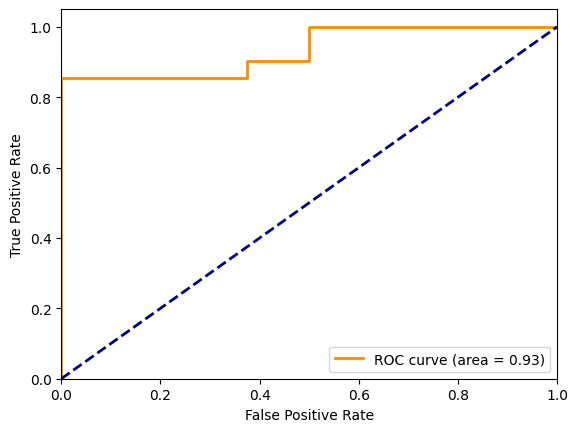

In [24]:
ROI = "roi2" # choose from: ['roi1', 'roi4', 'roi2', 'whole_tumour', 'brain']
single_acquisitions = ["DTI_eddy_FA", "FLAIR", "DWI","T1_contrast", "DTI_eddy_MD"]

def get_paths(acquisitions):
    environment = os.environ.get('PYRADIOMICS_ENV', 'local')  # Default to 'local' if the environment variable is not set
    
    if environment == 'local':
        base_directory = "/Users/Gabriel/MSc_Dissertation/pyRadiomics/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')
    elif environment == 'cluster':
        base_directory = "/cluster/project2/UCSF_PDGM_dataset/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')
    else:
        raise ValueError("Unknown environment: please set PYRADIOMICS_ENV to 'local' or 'cluster'")

    return base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir

def process_target_columns(df):
    df = df.copy()
    grade_mapping = {2: 0, 3: 1, 4: 2}
    df["WHO CNS Grade"] = df["WHO CNS Grade"].map(grade_mapping)
    
    # Update 'IDH' values to be dichotomous 
    df.loc[df["IDH"] != "wildtype", "IDH"] = "mutant"

    # Encode IDH column in 1s and 0s
    df["IDH"] = pd.Categorical(df["IDH"], categories=["mutant", "wildtype"]).codes

    return df

def load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path):
    # Extract unique identifier from path
    def get_id(path):
        filename = os.path.basename(path)
        identifier = filename.replace(".csv", "")
        return identifier

    # Load data training 
    train_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in train_features_paths], axis=1)
    train_meta_data = pd.read_csv(train_data_path)
    train_meta_data["ID"] = train_meta_data["ID"].str.extract('(\d+)').astype(int)
    train_meta_data.set_index("ID", inplace=True)
    train_merged_data = train_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(train_features_data, left_index=True, right_index=True)
    train_target_columns = process_target_columns(train_merged_data[["WHO CNS Grade", "IDH"]])
    X_train = train_merged_data.drop(train_target_columns, axis=1)
    X_train["Sex"] = pd.Categorical(X_train["Sex"], categories=["M", "F"]).codes
    y_train = train_target_columns

    # Load data validation
    validation_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in validation_features_paths], axis=1)
    validation_meta_data = pd.read_csv(validation_data_path)
    validation_meta_data["ID"] = validation_meta_data["ID"].str.extract('(\d+)').astype(int)  # Add this line to convert 'ID' to int
    validation_meta_data.set_index("ID", inplace=True)
    validation_merged_data = validation_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(validation_features_data, left_index=True, right_index=True)
    validation_target_columns = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    X_validation = validation_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    X_validation["Sex"] = pd.Categorical(X_validation["Sex"], categories=["M", "F"]).codes 
    y_validation = validation_target_columns
    
    # Make sure that columns are in same order
    # Strip the "_training" and "_validation" parts from the column names
    X_train_columns_stripped = X_train.columns.str.replace("_training", "")
    X_validation_columns_stripped = X_validation.columns.str.replace("_validation", "")

    # Assert that the modified column names are the same
    assert (X_train_columns_stripped == X_validation_columns_stripped).all(), "The order of the columns in X_train and X_validation is not the same"

    
    return X_train, y_train, X_validation, y_validation

def train_model(X_train, y_train):
    params = {
        "objective": "binary:logistic", # IDH prediction is a binary classification task
        "learning_rate": 0.1,
        "max_depth": 5,
        "n_estimators": 100,
        "seed": 42
    }

    xgb_clf = xgb.XGBClassifier(**params)

    # Fit the model to the IDH column only
    xgb_clf.fit(X_train, y_train["IDH"])
    return xgb_clf

def make_predictions(clf, X_test):
    y_pred = clf.predict(X_test)
    return y_pred

def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(f'/Users/Gabriel/Desktop/IDH_Figure_{ROI}.png', dpi=300)
    plt.show()
    
def main():
    results = []
    acquisitions = tuple(single_acquisitions)
    
    # Get paths
    base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir = get_paths(acquisitions)


    # Load data
    X_train, y_train, X_validation, y_validation = load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path)

    # Train the model
    clf = train_model(X_train, y_train)

    # Make predictions on the validation set
    y_pred = make_predictions(clf, X_validation)

    # Assess model performance
    target_columns = ["IDH"]
    result = {
        "Acquisition": acquisitions,
        "IDH balanced-accuracy": balanced_accuracy_score(y_validation["IDH"], y_pred),
    }

    results.append(result)

    # Make predictions on the validation set with probabilities
    y_scores = clf.predict_proba(X_validation)[:, 1]

    # Compute ROC-AUC for IDH
    auc = roc_auc_score(y_validation['IDH'], y_scores)
    print(f"AUC: {auc}")

    # Plot ROC curve for IDH only
    plot_roc_curve(y_validation['IDH'], y_scores, 'IDH')

    results_df = pd.DataFrame(results)
    
    return results_df, eval_dir

results_df, eval_dir = main()


## Only WHO output

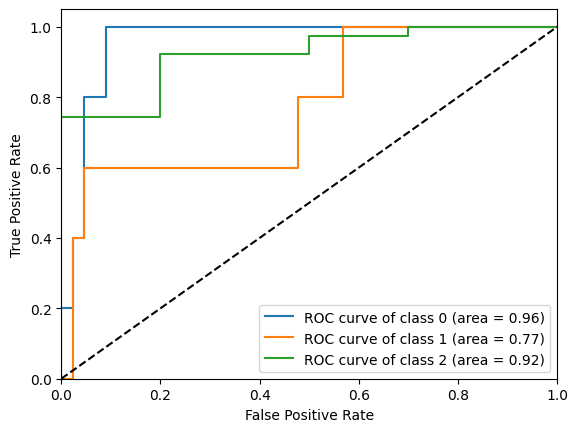

In [25]:
import os
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

#ROI = "whole_tumour"  
single_acquisitions = ["DTI_eddy_FA", "FLAIR", "DWI","T1_contrast", "DTI_eddy_MD"]

def get_paths(acquisitions):
    environment = os.environ.get('PYRADIOMICS_ENV', 'local')  # Default to 'local' if the environment variable is not set
    
    if environment == 'local':
        base_directory = "/Users/Gabriel/MSc_Dissertation/pyRadiomics/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')
    elif environment == 'cluster':
        base_directory = "/cluster/project2/UCSF_PDGM_dataset/"
        train_features_paths = [os.path.join(base_directory, "Training/extracted_features/" + ROI + "/training_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        train_data_path = os.path.join(base_directory, "Training/training_data.csv")
        validation_features_paths = [os.path.join(base_directory, "Validation/extracted_features/" + ROI + "/validation_firstorder_" + "original_" + acquisition + "_" + ROI  + ".csv") for acquisition in acquisitions]
        validation_data_path = os.path.join(base_directory, "Validation/validation_data.csv")
        eval_dir = os.path.join(base_directory,"Model_performance", f'{ROI}_XGBoost_evaluation.csv')
    else:
        raise ValueError("Unknown environment: please set PYRADIOMICS_ENV to 'local' or 'cluster'")

    return base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir

def process_target_columns(df):
    df = df.copy()
    grade_mapping = {2: 0, 3: 1, 4: 2}
    df["WHO CNS Grade"] = df["WHO CNS Grade"].map(grade_mapping)
    
    # Update 'IDH' values to be dichotomous 
    df.loc[df["IDH"] != "wildtype", "IDH"] = "mutant"

    # Encode IDH column in 1s and 0s
    df["IDH"] = pd.Categorical(df["IDH"], categories=["mutant", "wildtype"]).codes
    return df

def load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path):
    # Extract unique identifier from path
    def get_id(path):
        filename = os.path.basename(path)
        identifier = filename.replace(".csv", "")
        return identifier

    # Load data training 
    train_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in train_features_paths], axis=1)
    train_meta_data = pd.read_csv(train_data_path)
    train_meta_data["ID"] = train_meta_data["ID"].str.extract('(\d+)').astype(int)
    train_meta_data.set_index("ID", inplace=True)
    train_merged_data = train_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(train_features_data, left_index=True, right_index=True)
    train_target_columns = process_target_columns(train_merged_data[["WHO CNS Grade", "IDH"]])
    X_train = train_merged_data.drop(train_target_columns, axis=1)
    X_train["Sex"] = pd.Categorical(X_train["Sex"], categories=["M", "F"]).codes
    y_train = train_target_columns

    # Load data validation
    validation_features_data = pd.concat([(pd.read_csv(path).add_suffix('_' + get_id(path))).rename(columns={pd.read_csv(path).add_suffix('_' + get_id(path)).columns[0]: "ID"}).astype(float).set_index("ID") for path in validation_features_paths], axis=1)
    validation_meta_data = pd.read_csv(validation_data_path)
    validation_meta_data["ID"] = validation_meta_data["ID"].str.extract('(\d+)').astype(int)  # Add this line to convert 'ID' to int
    validation_meta_data.set_index("ID", inplace=True)
    validation_merged_data = validation_meta_data[['Sex', 'Age at MRI', 'WHO CNS Grade', 'IDH']].merge(validation_features_data, left_index=True, right_index=True)
    validation_target_columns = process_target_columns(validation_merged_data[["WHO CNS Grade", "IDH"]])
    X_validation = validation_merged_data.drop(["WHO CNS Grade", "IDH"], axis=1)
    X_validation["Sex"] = pd.Categorical(X_validation["Sex"], categories=["M", "F"]).codes 
    y_validation = validation_target_columns
    
    # Make sure that columns are in same order
    # Strip the "_training" and "_validation" parts from the column names
    X_train_columns_stripped = X_train.columns.str.replace("_training", "")
    X_validation_columns_stripped = X_validation.columns.str.replace("_validation", "")

    # Assert that the modified column names are the same
    assert (X_train_columns_stripped == X_validation_columns_stripped).all(), "The order of the columns in X_train and X_validation is not the same"

    #drop IDH
    
    y_train = y_train.drop('IDH', axis=1)
    y_validation = y_validation.drop('IDH', axis=1)

    return X_train, y_train, X_validation, y_validation

def train_model(X_train, y_train):
    params = {
        "objective": "multi:softprob",
        "learning_rate": 0.1,
        "max_depth": 5,
        "n_estimators": 100,
        "seed": 42,
        "num_class": 3
    }

    xgb_clf = xgb.XGBClassifier(**params)
    clf = OneVsRestClassifier(xgb_clf).fit(X_train, y_train)
    return clf

def make_predictions(clf, X_test):
    y_pred = clf.predict(X_test)
    return y_pred

def plot_roc_curve(y_test, y_score, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(f'/Users/Gabriel/Desktop/WHO_Figure_{ROI}.png', dpi=300)
    plt.show()

def main():
    results = []
    acquisitions = tuple(single_acquisitions)
    
    # Get paths
    base_directory, train_features_paths, train_data_path, validation_features_paths, validation_data_path, eval_dir = get_paths(acquisitions)

    # Load data
    X_train, y_train, X_validation, y_validation = load_data(train_features_paths, train_data_path, validation_features_paths, validation_data_path)

    # Binarize the output for multi-label ROC
    lb = LabelBinarizer()
    y_train_bin = lb.fit_transform(y_train)
    y_validation_bin = lb.transform(y_validation)

    # Train the model on 'WHO CNS Grade' only
    clf = train_model(X_train, y_train_bin)

    # Make predictions on the validation set
    y_score = clf.predict_proba(X_validation)

    # Compute ROC-AUC for each class in 'WHO CNS Grade'
    plot_roc_curve(y_validation_bin, y_score, n_classes=3)

main()


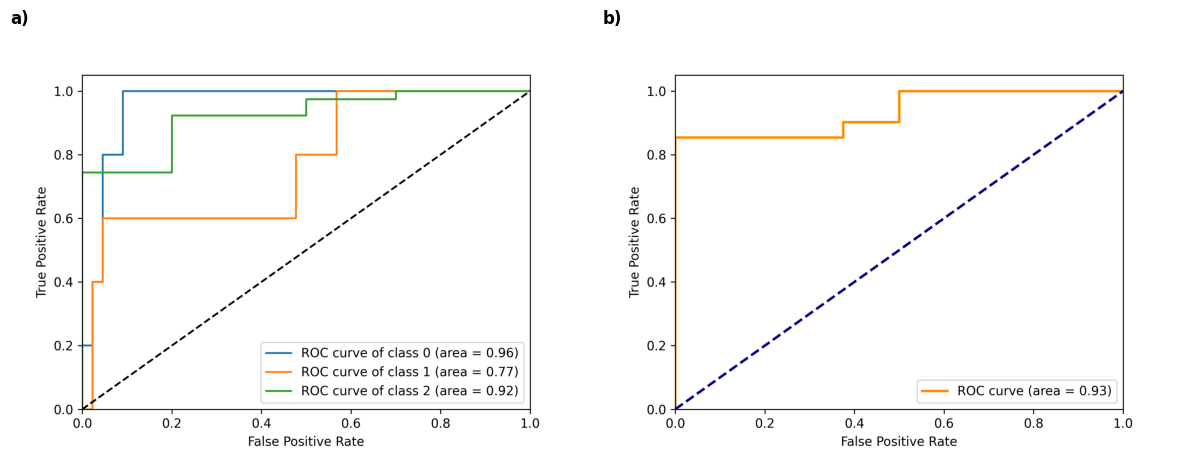

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Load both png figs
fig1 = mpimg.imread(f'/Users/Gabriel/Desktop/WHO_Figure_{ROI}.png')
fig2 = mpimg.imread(f'/Users/Gabriel/Desktop/IDH_Figure_{ROI}.png')

# Display the images in subplots
axs[0].imshow(fig1)
axs[0].axis('off')
axs[0].annotate("a)", xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

axs[1].imshow(fig2)
axs[1].axis('off')
axs[1].annotate("b)", xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig(f'/Users/Gabriel/Desktop/AUCROC_{ROI}.png', dpi=300)


# Show the figure
plt.show()